# Volcanic Eruption Impact on Climate: Surface Downward Solar Radiation
* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [2]:
from plotsetting import *
from geoplots import mapplot
import matplotlib.pyplot as plt
plt.rcParams['hatch.color']='g'
import geoxarray
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import ttest_1samp

from data_CTL1860 import open_ensemble as get_ctl
from data_agung import open_data as get_agung
from data_chichon import open_data as get_chichon

%matplotlib notebook
!date

Mon Feb 12 10:58:02 EST 2018


In [3]:
year_agung = 1963
year_chichon = 1982
data_name = 'swdn_sfc'
#ens = range(1,31)
ens = range(1,30+1)

new_names = {'grid_xt': 'lon', 'grid_yt': 'lat'}
da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_agung).rename(new_names).load()
da_ctl_c = get_ctl(data_name, ens=ens, year_volcano=year_chichon).rename(new_names).load()#control with years shifted to Chichon
da_agung = get_agung(data_name, ens=ens).rename(new_names).load()
da_chichon = get_chichon(data_name, ens=ens).rename(new_names).load()

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


### Global Mean Surface Anomaly

In [4]:
ts_ctl = da_ctl.geo.fldmean().load()
ts_agung = da_agung.geo.fldmean().load()
ts_chichon = da_chichon.geo.fldmean().load()

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_agung = ts_agung.groupby('time.month') - ts_clim
ts_chichon = ts_chichon.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

# shift Chichon year from 1982 to 1963 to compare it with Agung
ts_chichon['time'] = ts_chichon['time'].to_index().shift((year_agung-year_chichon)*12, 'MS')

<IPython.core.display.Javascript object>


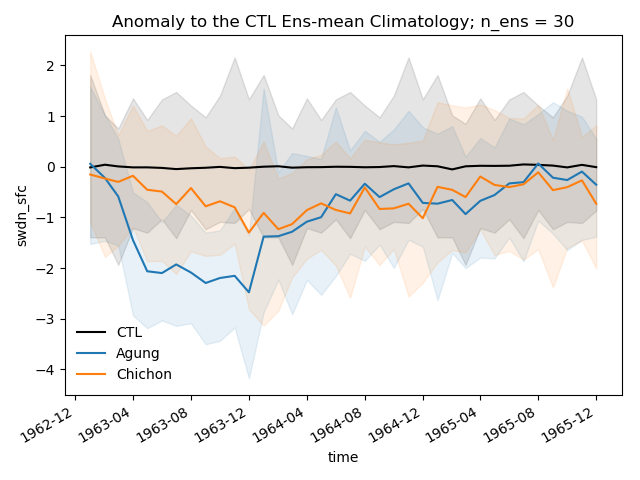

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


In [5]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
    ts_ctl.min('en'),
    ts_ctl.max('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_agung.time.to_index().to_pydatetime(),
    ts_agung.min('en'),
    ts_agung.max('en'),
    color='C0', alpha=0.1)
plt.fill_between(ts_chichon.time.to_index().to_pydatetime(),
    ts_chichon.min('en'),
    ts_chichon.max('en'),
    color='C1', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_agung.mean('en').plot(color='C0', label='Agung')
ts_chichon.mean('en').plot(color='C1', label='Chichon')
plt.legend(loc='lower left')
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
plt.tight_layout()

### Ensemble-mean Seasonal-mean Anomaly Map

#### Agung

In [6]:
daa = da_agung - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


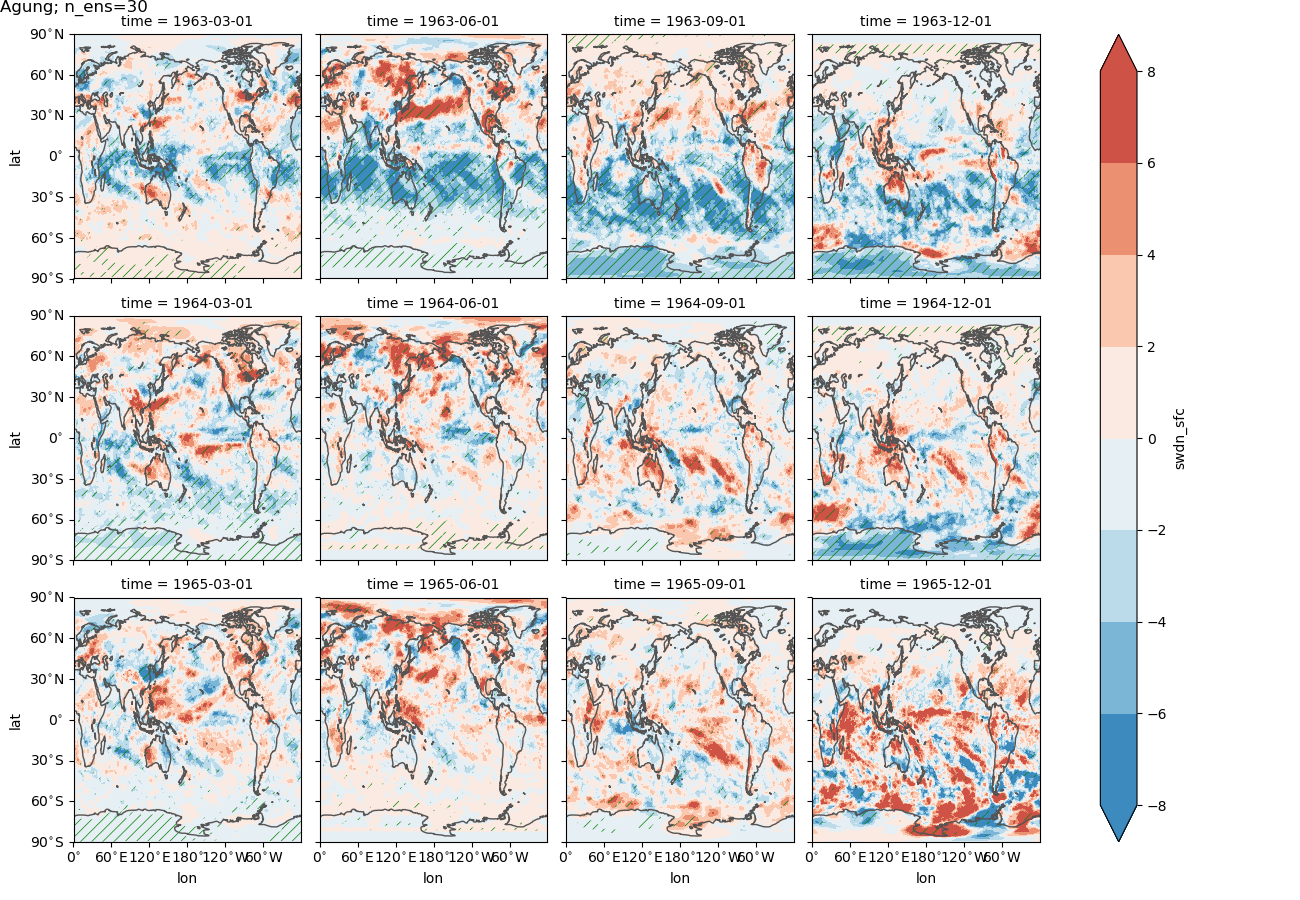

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Agung; n_ens=30')

In [7]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'Agung; n_ens={len(ens)}', x=0, y=1, ha='left')

<IPython.core.display.Javascript object>


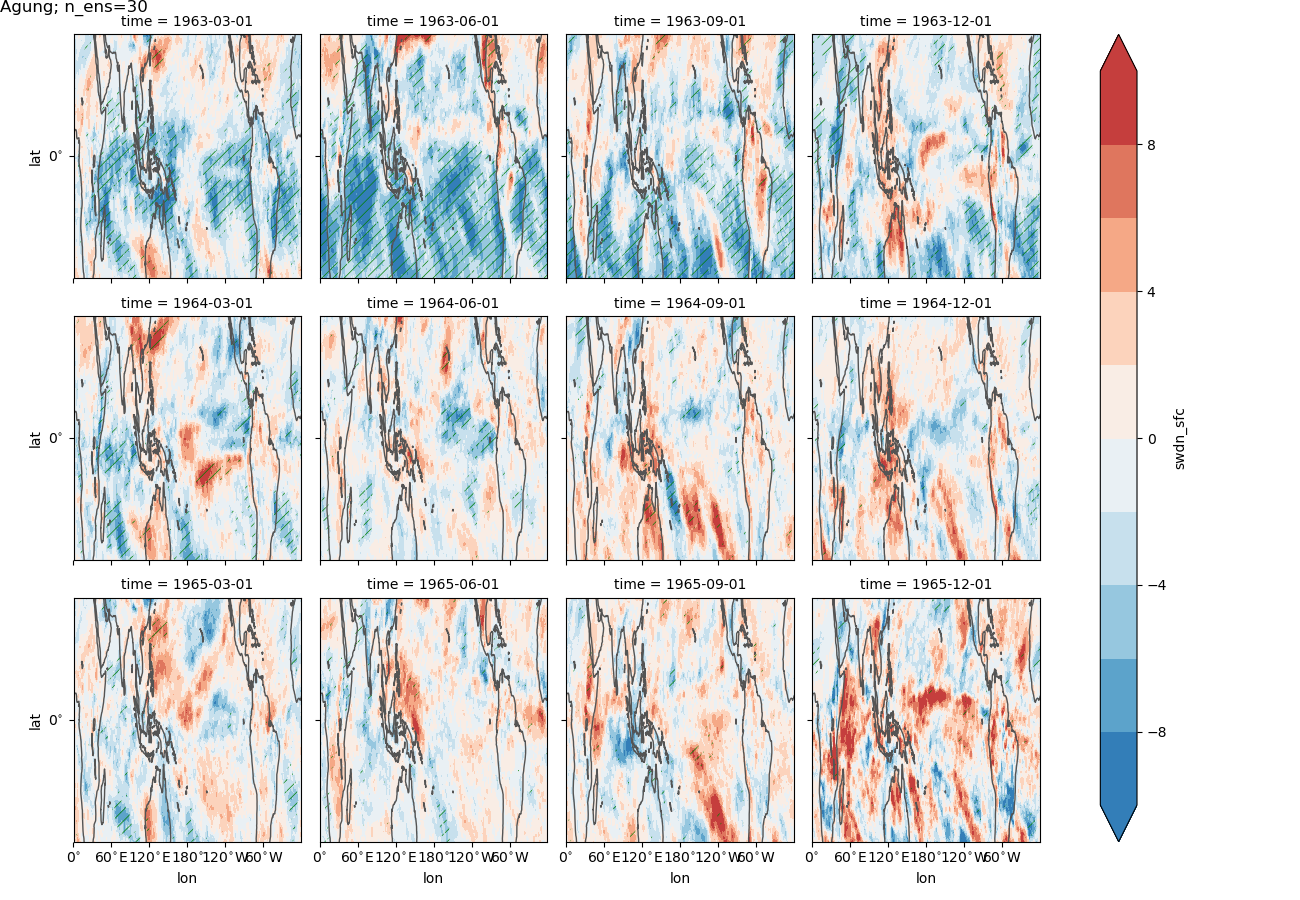

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Agung; n_ens=30')

In [8]:
# tropics only
latrange = slice(-30,30)
f = da.sel(lat=latrange).plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).sel(lat=latrange).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'Agung; n_ens={len(ens)}', x=0, y=1, ha='left')

#### Chichon

In [9]:
daa = da_chichon - da_ctl_c# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


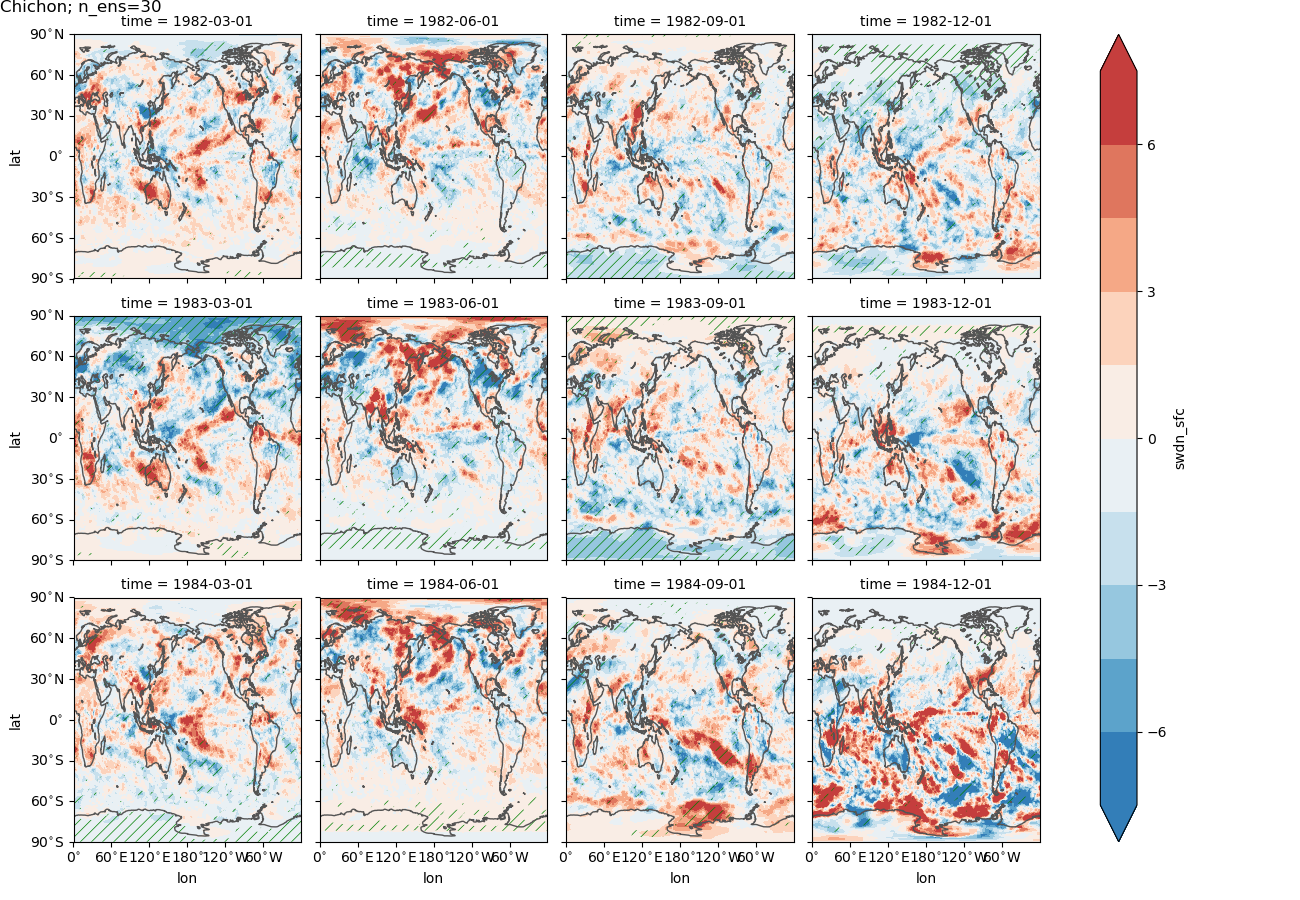

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; n_ens=30')

In [10]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'Chichon; n_ens={len(ens)}', x=0, y=1, ha='left')

<IPython.core.display.Javascript object>


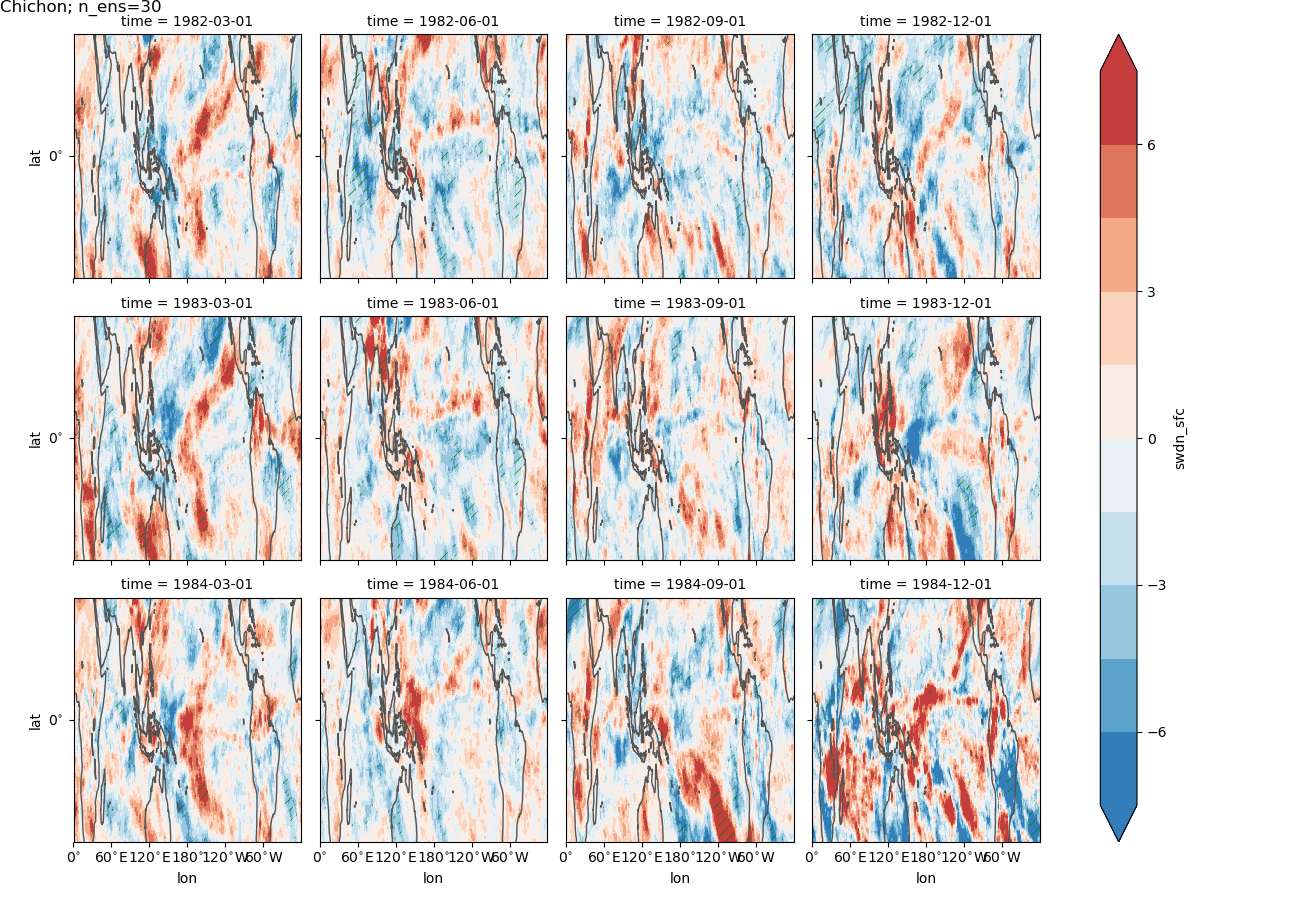

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; n_ens=30')

In [11]:
# tropics only
tropics = slice(-30,30)
f = da.sel(lat=tropics).plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).sel(lat=tropics).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'Chichon; n_ens={len(ens)}', x=0, y=1, ha='left')

### Ensemble-mean Zonal-mean Anomaly

### Agung

In [12]:
daa = da_agung - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


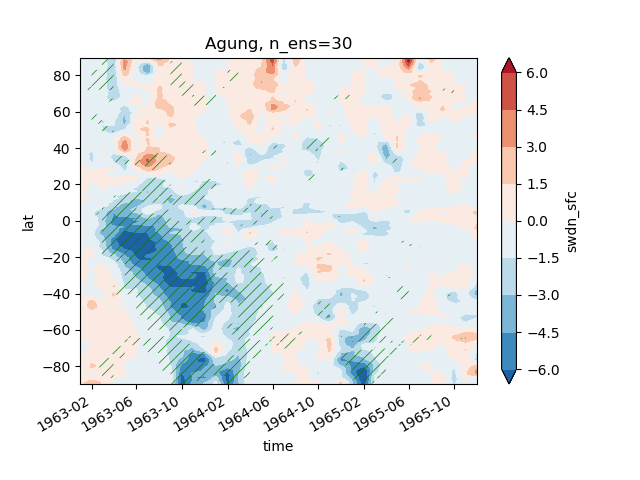

Text(0.5,1,'Agung, n_ens=30')

In [13]:
# %matplotlib inline
# plt.rcParams['figure.dpi'] = 120
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0)
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'Agung, n_ens={len(ens)}')

### Chichon

In [14]:
daa = da_chichon - da_ctl_c# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


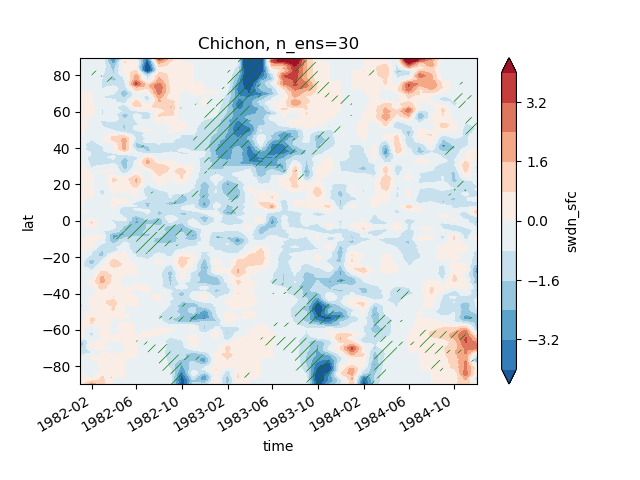

Text(0.5,1,'Chichon, n_ens=30')

In [15]:
# %matplotlib inline
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0)
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'Chichon, n_ens={len(ens)}')